In [1]:
import os
import cv2
import tensorflow
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json
from tensorflow.keras.optimizers import Adam
from keras.layers import ELU, LeakyReLU
from keras.utils import plot_model
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
img_files = next(os.walk('/content/drive/MyDrive/Skin/skin/ISIC-2017_Training_Data/ISIC-2017_Training_Data'))[2]
msk_files = next(os.walk('/content/drive/MyDrive/Skin/skin/ISIC-2017_Training_Part1_GroundTruth/ISIC-2017_Training_Part1_GroundTruth'))[2]

img_files.sort()
msk_files.sort()

print(len(img_files))
print(len(msk_files))




X = []
Y = []

for img_fl in tqdm(img_files):
    if(img_fl.split('.')[-1]=='jpg'):


        img = cv2.imread('/content/drive/MyDrive/Skin/skin/ISIC-2017_Training_Data/ISIC-2017_Training_Data/{}'.format(img_fl), cv2.IMREAD_COLOR)
        resized_img = cv2.resize(img,(128,128), interpolation = cv2.INTER_CUBIC)

        X.append(resized_img)

        msk = cv2.imread('/content/drive/MyDrive/Skin/skin/ISIC-2017_Training_Part1_GroundTruth/ISIC-2017_Training_Part1_GroundTruth/{}'.format(img_fl.split('.')[0]+'_segmentation.png'), cv2.IMREAD_GRAYSCALE)
        resized_msk = cv2.resize(msk,(128,128), interpolation = cv2.INTER_CUBIC)

        Y.append(resized_msk)


2000
2000


 96%|█████████▌| 1924/2000 [27:58<02:19,  1.83s/it]

In [ ]:
print(len(X))
print(len(Y))

X = np.array(X)
Y = np.array(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Y_train = Y_train.reshape((Y_train.shape[0],Y_train.shape[1],Y_train.shape[2],1))
Y_test = Y_test.reshape((Y_test.shape[0],Y_test.shape[1],Y_test.shape[2],1))

X_train = X_train / 255
X_test = X_test / 255
Y_train = Y_train / 255
Y_test = Y_test / 255

Y_train = np.round(Y_train,0)
Y_test = np.round(Y_test,0)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

In [ ]:
X_train1, X_test_do, Y_train1, Y_test_d0 = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [ ]:
print(X_train1.shape)
print(Y_train1.shape)
print(X_test_do.shape)
print(Y_test_d0.shape)

In [2]:
import tensorflow as tf
from sklearn.utils.extmath import cartesian
import math
def dice_coef(y_true, y_pred):
    smooth = 0.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jacard(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)

    return intersection/union

def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall

def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth)
    return tp

def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn
def cdist(A, B):
    """
    Computes the pairwise Euclidean distance matrix between two tensorflow matrices A & B, similiar to scikit-learn cdist.
    For example:
    A = [[1, 2],
         [3, 4]]
    B = [[1, 2],
         [3, 4]]
    should return:
        [[0, 2.82],
         [2.82, 0]]
    :param A: m_a x n matrix
    :param B: m_b x n matrix
    :return: euclidean distance matrix (m_a x m_b)
    """
    # squared norms of each row in A and B
    na = tf.reduce_sum(tf.square(A), 1)
    nb = tf.reduce_sum(tf.square(B), 1)

    # na as a row and nb as a co"lumn vectors
    na = tf.reshape(na, [-1, 1])
    nb = tf.reshape(nb, [1, -1])

    # return pairwise euclidead difference matrix
    D = tf.sqrt(tf.maximum(na - 2 * tf.matmul(A, B, False, True) + nb, 0.0))
    return D


def weighted_hausdorff_distance(w, h, alpha):
    all_img_locations = tf.convert_to_tensor(cartesian([np.arange(w), np.arange(h)]), dtype=tf.float32)
    max_dist = math.sqrt(w ** 2 + h ** 2)

    def hausdorff_loss(y_true, y_pred):
        def loss(y_true, y_pred):
            eps = 1e-6
            y_true = K.reshape(y_true, [w, h])
            gt_points = K.cast(tf.where(y_true > 0.5), dtype=tf.float32)
            num_gt_points = tf.shape(gt_points)[0]
            y_pred = K.flatten(y_pred)
            p = y_pred
            p_replicated = tf.squeeze(K.repeat(tf.expand_dims(p, axis=-1), num_gt_points))
            d_matrix = cdist(all_img_locations, gt_points)
            num_est_pts = tf.reduce_sum(p)
            term_1 = (1 / (num_est_pts + eps)) * K.sum(p * K.min(d_matrix, 1))

            d_div_p = K.min((d_matrix + eps) / (p_replicated ** alpha + (eps / max_dist)), 0)
            d_div_p = K.clip(d_div_p, 0, max_dist)
            term_2 = K.mean(d_div_p, axis=0)

            return term_1 + term_2

        batched_losses = tf.map_fn(lambda x:
                                   loss(x[0], x[1]),
                                   (y_true, y_pred),
                                   dtype=tf.float32)
        return K.mean(tf.stack(batched_losses))

    return hausdorff_loss

In [13]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, BatchNormalization,add, Activation, UpSampling2D,Dense,Reshape,multiply
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

IMG_HEIGHT=128
IMG_WIDTH=128
IMG_CHANNELS=3

def expend_as(tensor, rep):
     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def double_conv_layer(x, filter_size, size, dropout, batch_norm=False):
    '''
    construction of a double convolutional layer using
    SAME padding
    RELU nonlinear activation function
    :param x: input
    :param filter_size: size of convolutional filter
    :param size: number of filters
    :param dropout: FLAG & RATE of dropout.
            if < 0 dropout cancelled, if > 0 set as the rate
    :param batch_norm: flag of if batch_norm used,
            if True batch normalization
    :return: output of a double convolutional layer
    '''
    axis = 3
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=axis)(conv)
    conv = layers.Activation('relu')(conv)
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=axis)(conv)
    conv = layers.Activation('relu')(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=axis)(shortcut)

    res_path = layers.add([shortcut, conv])
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :param input:   down-dim feature map
    :param out_size:output channel number
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Multiply, Add, Activation, Concatenate, MaxPooling2D, UpSampling2D

def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    shared_layer_one = tf.keras.layers.Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = tf.keras.layers.Dense(channel, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    avg_pool = tf.keras.layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = tf.keras.layers.Reshape((1,1,channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = tf.keras.layers.GlobalMaxPooling2D()(input_feature)
    max_pool = tf.keras.layers.Reshape((1,1,channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = tf.keras.layers.Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7

    avg_pool = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(input_feature)
    max_pool = tf.keras.layers.Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(input_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    cbam_feature = Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)

    return Multiply()([input_feature, cbam_feature])

def attention_block(x, g, inter_channel):
    theta_x = Conv2D(inter_channel, (2, 2), strides=(2, 2), padding='same')(x)
    phi_g = Conv2D(inter_channel, (1, 1), padding='same')(g)
    concat_xg = Add()([theta_x, phi_g])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    upsample_psi = UpSampling2D(size=(2, 2))(sigmoid_xg)
    upsample_psi = tf.keras.layers.Lambda(lambda x, repnum: tf.repeat(x, repnum, axis=3), arguments={'repnum': x.shape[3]})(upsample_psi)
    y = Multiply()([upsample_psi, x])
    result = Conv2D(x.shape[3], (1, 1), padding='same')(y)
    result = BatchNormalization()(result)
    return result



def NADR_new():
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
  s = inputs
  #LAYER 1
  y_1 = Conv2D(filters=32, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(s)
  #LAYER 2

  y_1 = Activation('relu')(y_1)
  y_1 = Conv2D(filters=32, kernel_size=3, dilation_rate=1, padding='same', use_bias=False)(y_1)
  y_1 = BatchNormalization()(y_1)
  y_1 = Activation('relu')(y_1)
  y_1 = Conv2D(filters=32, kernel_size=3, dilation_rate=1, padding='same', use_bias=False)(y_1)

  y_2= BatchNormalization()(s)
  y_2 = Activation('relu')(y_2)
  y_2 = Conv2D(filters=32, kernel_size=3, dilation_rate=3,strides=1, padding='same', use_bias=False)(y_2)
  y_2 = BatchNormalization()(y_2)
  y_2 = Activation('relu')(y_2)
  y_2 = Conv2D(filters=32, kernel_size=3, dilation_rate=3,strides=1, padding='same', use_bias=False)(y_2)

  y_15= BatchNormalization()(s)
  y_15 = Activation('relu')(y_15)
  y_15 = Conv2D(filters=32, kernel_size=3, dilation_rate=15,strides=1, padding='same', use_bias=False)(y_15)
  y_15 = BatchNormalization()(y_15)
  y_15 = Activation('relu')(y_15)
  y_15 = Conv2D(filters=32, kernel_size=3, dilation_rate=15,strides=1, padding='same', use_bias=False)(y_15)

  y_31= BatchNormalization()(s)
  y_31 = Activation('relu')(y_31)
  y_31 = Conv2D(filters=32, kernel_size=3, dilation_rate=31,strides=1, padding='same', use_bias=False)(y_31)
  y_31 = BatchNormalization()(y_15)
  y_31 = Activation('relu')(y_15)
  y_31 = Conv2D(filters=32, kernel_size=3, dilation_rate=31,strides=1, padding='same', use_bias=False)(y_31)


  y_la_1=add([y_1,y_2,y_15,y_31])

  #LAYER 3

  y2 = Conv2D(filters=64, kernel_size=1, dilation_rate=1,strides=2, padding='same', use_bias=False)(y_la_1)
  #LAYER 4
  y_1_2 = BatchNormalization()(y2)
  y_1_2 = Activation('relu')(y_1_2)
  y_1_2 = Conv2D(filters=64, kernel_size=3, dilation_rate=1, padding='same', use_bias=False)(y_1_2)
  y_1_2 = BatchNormalization()(y_1_2)
  y_1_2 = Activation('relu')(y_1_2)
  y_1_2 = Conv2D(filters=64, kernel_size=3, dilation_rate=1, padding='same', use_bias=False)(y_1_2)

  y_2_2= BatchNormalization()(y2)
  y_2_2 = Activation('relu')(y_2_2)
  y_2_2 = Conv2D(filters=64, kernel_size=3, dilation_rate=3,strides=1, padding='same', use_bias=False)(y_2_2)
  y_2_2 = BatchNormalization()(y_2_2)
  y_2_2 = Activation('relu')(y_2_2)
  y_2_2 = Conv2D(filters=64, kernel_size=3, dilation_rate=3,strides=1, padding='same', use_bias=False)(y_2_2)

  y_15_2= BatchNormalization()(y2)
  y_15_2 = Activation('relu')(y_15_2)
  y_15_2 = Conv2D(filters=64, kernel_size=3, dilation_rate=15,strides=1, padding='same', use_bias=False)(y_15_2)
  y_15_2 = BatchNormalization()(y_15_2)
  y_15_2 = Activation('relu')(y_15_2)
  y_15_2 = Conv2D(filters=64, kernel_size=3, dilation_rate=15,strides=1, padding='same', use_bias=False)(y_15_2)

  y_31_2= BatchNormalization()(y2)
  y_31_2 = Activation('relu')(y_31_2)
  y_31_2 = Conv2D(filters=64, kernel_size=3, dilation_rate=31,strides=1, padding='same', use_bias=False)(y_31_2)
  y_31_2 = BatchNormalization()(y_15_2)
  y_31_2 = Activation('relu')(y_15_2)
  y_31_2 = Conv2D(filters=64, kernel_size=3, dilation_rate=31,strides=1, padding='same', use_bias=False)(y_31_2)

  y_la_2=layers.add([y_1_2,y_2_2,y_15_2,y_31_2])
  #LAYER 5
  y3 = Conv2D(filters=128, kernel_size=1, dilation_rate=1,strides=2, padding='same', use_bias=False)(y_la_2)
  #LAYER 6
  y_1_3 = BatchNormalization()(y3)
  y_1_3 = Activation('relu')(y_1_3)
  y_1_3 = Conv2D(filters=128, kernel_size=3, dilation_rate=1, padding='same', use_bias=False)(y_1_3)
  y_1_3 = BatchNormalization()(y_1_3)
  y_1_3 = Activation('relu')(y_1_3)
  y_1_3 = Conv2D(filters=128, kernel_size=3, dilation_rate=1, padding='same', use_bias=False)(y_1_3)

  y_2_3= BatchNormalization()(y3)
  y_2_3 = Activation('relu')(y_2_3)
  y_2_3 = Conv2D(filters=128, kernel_size=3, dilation_rate=3,strides=1, padding='same', use_bias=False)(y_2_3)
  y_2_3 = BatchNormalization()(y_2_3)
  y_2_3 = Activation('relu')(y_2_3)
  y_2_3 = Conv2D(filters=128, kernel_size=3, dilation_rate=3,strides=1, padding='same', use_bias=False)(y_2_3)

  y_15_3= BatchNormalization()(y3)
  y_15_3 = Activation('relu')(y_15_3)
  y_15_3 = Conv2D(filters=128, kernel_size=3, dilation_rate=15,strides=1, padding='same', use_bias=False)(y_15_3)
  y_15_3 = BatchNormalization()(y_15_3)
  y_15_3 = Activation('relu')(y_15_3)
  y_15_3 = Conv2D(filters=128, kernel_size=3, dilation_rate=15,strides=1, padding='same', use_bias=False)(y_15_3)


  y_la_3=add([y_1_3,y_2_3,y_15_3])
  #LAYER 7
  y4 = Conv2D(filters=256, kernel_size=1, dilation_rate=1,strides=2, padding='same', use_bias=False)(y_la_3)
  #LAYER 8
  y_1_4 = BatchNormalization()(y4)
  y_1_4 = Activation('relu')(y_1_4)
  y_1_4 = Conv2D(filters=256, kernel_size=3, dilation_rate=1, padding='same', use_bias=False)(y_1_4)
  y_1_4 = BatchNormalization()(y_1_4)
  y_1_4 = Activation('relu')(y_1_4)
  y_1_4 = Conv2D(filters=256, kernel_size=3, dilation_rate=1, padding='same', use_bias=False)(y_1_4)

  y_2_4= BatchNormalization()(y4)
  y_2_4 = Activation('relu')(y_2_4)
  y_2_4 = Conv2D(filters=256, kernel_size=3, dilation_rate=3,strides=1, padding='same', use_bias=False)(y_2_4)
  y_2_4 = BatchNormalization()(y_2_4)
  y_2_4 = Activation('relu')(y_2_4)
  y_2_4 = Conv2D(filters=256, kernel_size=3, dilation_rate=3,strides=1, padding='same', use_bias=False)(y_2_4)

  y_15_4= BatchNormalization()(y4)
  y_15_4 = Activation('relu')(y_15_4)
  y_15_4 = Conv2D(filters=256, kernel_size=3, dilation_rate=15,strides=1, padding='same', use_bias=False)(y_15_4)
  y_15_4 = BatchNormalization()(y_15_4)
  y_15_4 = Activation('relu')(y_15_4)
  y_15_4 = Conv2D(filters=256, kernel_size=3, dilation_rate=15,strides=1, padding='same', use_bias=False)(y_15_4)


  y_la_4=add([y_1_4,y_2_4,y_15_4])
  #LAYER 9
  y5 = Conv2D(filters=512, kernel_size=1, dilation_rate=1,strides=2, padding='same', use_bias=False)(y_la_4)
  #LAYER 10
  y_1_5 = BatchNormalization()(y5)
  y_1_5 = Activation('relu')(y_1_5)
  y_1_5 = Conv2D(filters=512, kernel_size=3, dilation_rate=1, padding='same', use_bias=False)(y_1_5)
  y_1_5 = BatchNormalization()(y_1_5)
  y_1_5 = Activation('relu')(y_1_5)
  y_1_5 = Conv2D(filters=512, kernel_size=3, dilation_rate=1, padding='same', use_bias=False)(y_1_5)
  #LAYER 11
  y6 = Conv2D(filters=1024, kernel_size=1, dilation_rate=1,strides=2, padding='same', use_bias=False)(y_1_5)
  #LAYER 12
  y_1_6 = BatchNormalization()(y6)
  y_1_6 = Activation('relu')(y_1_6)
  y_1_6 = Conv2D(filters=1024, kernel_size=3, dilation_rate=1, padding='same', use_bias=False)(y_1_6)
  y_1_6 = BatchNormalization()(y_1_6)
  y_1_6 = Activation('relu')(y_1_6)
  y_1_6 = Conv2D(filters=1024, kernel_size=3, dilation_rate=1, padding='same', use_bias=False)(y_1_6)
  shape = y_1_6.shape
  #LAYER 13 PSP
  y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]))(y_1_6)
  y_pool = Conv2D(filters=256, kernel_size=1,dilation_rate=1,strides=2, padding='same', use_bias=False)(y_pool)
  y_pool = BatchNormalization()(y_pool)
  y_pool = Activation('relu')(y_pool)
  y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

  y1_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y_1_6)
  y1_1 = BatchNormalization()(y1_1)
  y1_1 = Activation('relu')(y1_1)

  y1_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(y_1_6)
  y1_6 = BatchNormalization()(y1_6)
  y1_6 = Activation('relu')(y1_6)

  y1_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(y_1_6)
  y1_12 = BatchNormalization()(y1_12)
  y1_12 = Activation('relu')(y1_12)

  y1_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(y_1_6)
  y1_18 = BatchNormalization()(y1_18)
  y1_18 = Activation('relu')(y1_18)
  y_1_7 = Concatenate()([y_pool, y1_1, y1_6, y1_12, y1_18])
  FILTER_NUM=32
  batch_norm=False
  #gating_16 = gating_signal(y_1_7, 16*FILTER_NUM, batch_norm)
  att_16 = attention_block(y_1_5, y_1_7, 16*FILTER_NUM)

  #LAYER 14
  y_1_8 = UpSampling2D()(y_1_7)

  #LAYER 15
  y_1_9 = Concatenate()([y_1_8,att_16])

  #LAYER 16
  y_1_10 = BatchNormalization()(y_1_9)
  y_1_10= Activation('relu')(y_1_10)
  y_1_10 = Conv2D(filters=512, kernel_size=3, dilation_rate=1, padding='same', use_bias=False)(y_1_10)
  y_1_10 = BatchNormalization()(y_1_10)
  y_1_10 = Activation('relu')(y_1_10)
  y_1_10 = Conv2D(filters=512, kernel_size=3, dilation_rate=1, padding='same', use_bias=False)(y_1_10)

  #gating2_16 = gating_signal(y_1_10, 8*FILTER_NUM, batch_norm)
  att2_16 = attention_block(y_la_4, y_1_10, 8*FILTER_NUM)
  #LAYER 17

  y_1_11 = UpSampling2D()(y_1_10)

  #LAYER 18
  y_1_12 = Concatenate()([y_1_11,att2_16])

  #LAYER 19
  y_1_13 = BatchNormalization()(y_1_12)
  y_1_13= Activation('relu')(y_1_13)
  y_1_13 = Conv2D(filters=256, kernel_size=3, dilation_rate=1, padding='same', use_bias=False)(y_1_13)
  y_1_13 = BatchNormalization()(y_1_13)
  y_1_13 = Activation('relu')(y_1_13)
  y_1_13 = Conv2D(filters=256, kernel_size=3, dilation_rate=1, padding='same', use_bias=False)(y_1_13)

  #gating3_16 = gating_signal(y_1_13, 4*FILTER_NUM, batch_norm)
  att3_16 = attention_block(y_la_3, y_1_13, 4*FILTER_NUM)

  #LAYER 20

  y_2_13 = UpSampling2D()(y_1_13)

  #LAYER 21
  y_1_14 = Concatenate()([y_2_13,att3_16])

  #LAYER 22
  y_1_15 = BatchNormalization()(y_1_14)
  y_1_15= Activation('relu')(y_1_15)
  y_1_15 = Conv2D(filters=128, kernel_size=3, dilation_rate=1, padding='same', use_bias=False)(y_1_15)
  y_1_15 = BatchNormalization()(y_1_15)
  y_1_15 = Activation('relu')(y_1_15)
  y_1_15 = Conv2D(filters=128, kernel_size=3, dilation_rate=1, padding='same', use_bias=False)(y_1_15)


  #gating4_16 = gating_signal(y_1_15, 2*FILTER_NUM, batch_norm)
  att4_16 = attention_block(y_la_2, y_1_15, 2*FILTER_NUM)

  #LAYER 23

  y_1_16 = UpSampling2D()(y_1_15)

  #LAYER 24
  y_1_17 = Concatenate()([y_1_16,att4_16])

  #LAYER 25
  y_1_18 = BatchNormalization()(y_1_17)
  y_1_18= Activation('relu')(y_1_18)
  y_1_18 = Conv2D(filters=64, kernel_size=3, dilation_rate=1, padding='same', use_bias=False)(y_1_18)
  y_1_18 = BatchNormalization()(y_1_18)
  y_1_18 = Activation('relu')(y_1_18)
  y_1_18 = Conv2D(filters=64, kernel_size=3, dilation_rate=1, padding='same', use_bias=False)(y_1_18)

  #gating5_16 = gating_signal(y_1_18, FILTER_NUM, batch_norm)
  att5_16 = attention_block(y_la_1, y_1_18, FILTER_NUM)

  #LAYER 26

  y_1_19 = UpSampling2D()(y_1_18)

  #LAYER 27
  y_1_20 = Concatenate()([y_1_19,att5_16])
  #LAYER 28
  y_1_21 = BatchNormalization()(y_1_20)
  y_1_21= Activation('relu')(y_1_21)
  y_1_21 = Conv2D(filters=32, kernel_size=3, dilation_rate=1, padding='same', use_bias=False)(y_1_21)
  y_1_21 = BatchNormalization()(y_1_21)
  y_1_21 = Activation('relu')(y_1_21)
  y_1_21 = Conv2D(filters=32, kernel_size=3, dilation_rate=1, padding='same', use_bias=False)(y_1_21)


  #LAYER 29
  y_1_23 = Concatenate()([y_1_21, y_1])
  shape = y_1_23.shape
  #LAYER 30
  y1_pool = AveragePooling2D(pool_size=(shape[1], shape[2]))(y_1_23)
  y1_pool = Conv2D(filters=128, kernel_size=1,dilation_rate=1,strides=2, padding='same', use_bias=False)(y1_pool)
  y1_pool = BatchNormalization()(y1_pool)
  y1_pool = Activation('relu')(y1_pool)
  y1_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1_pool)

  y2_1 = Conv2D(filters=128, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y_1_23)
  y2_1 = BatchNormalization()(y2_1)
  y2_1 = Activation('relu')(y2_1)

  y2_6 = Conv2D(filters=128, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(y_1_23)
  y2_6 = BatchNormalization()(y2_6)
  y2_6 = Activation('relu')(y2_6)

  y2_12 = Conv2D(filters=128, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(y_1_23)
  y2_12 = BatchNormalization()(y2_12)
  y2_12 = Activation('relu')(y2_12)

  y2_18 = Conv2D(filters=128, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(y_1_23)
  y2_18 = BatchNormalization()(y2_18)
  y2_18 = Activation('relu')(y2_18)

  y_1_24 = Concatenate()([y1_pool, y2_1, y2_6, y2_12, y2_18])
  conv_final =Conv2D(1, kernel_size=(1,1))(y_1_24)

  conv_final = Activation('sigmoid')(conv_final)  #Change to softmax for multichannel
  model=Model(inputs,conv_final)
  return model
model=NADR_new()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 batch_normalization_533 (B  (None, 128, 128, 3)          12        ['input_11[0][0]']            
 atchNormalization)                                                                               
                                                                                                  
 activation_609 (Activation  (None, 128, 128, 3)          0         ['batch_normalization_533[0][0
 )                                                                  ]']                           
                                                                                            

In [14]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
!pip install segmentation_models

In [ ]:
!pip install keras_unet_collection

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [ ]:
from keras_unet_collection import losses

def hybrid_loss(y_true, y_pred):

    loss_focal = losses.focal_tversky(y_true, y_pred, alpha=0.5, gamma=4/3)
    loss_iou = losses.iou_seg(y_true, y_pred)

    # (x)
    loss_dice = losses.dice(y_true, y_pred)

    return loss_focal+loss_iou +loss_dice

In [ ]:
from tensorflow.keras.optimizers import Adam
import tensorflow
import segmentation_models as sm
model.compile(loss = hybrid_loss, optimizer=Adam(lr = 1e-3), metrics=['accuracy',dice_coef,jacard, confusion,tp,tn,recall_m,precision_m])
#print(model_Unet.summary())
#sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)


In [ ]:
steps_per_epoch = len(X_train1)//16
val_steps_per_epoch = len(X_test)//16

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

#ModelCheckpoint callback saves a model at some interval.
filepath="/content/drive/MyDrive/Skin/paper/weights/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5" #File name includes epoch and validation accuracy.
#Use Mode = max for accuracy and min for loss.
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
#early_stop = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
#This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('/content/drive/MyDrive/Skin/paper/weights/MADR_SKIN_logs.csv', separator=',', append=False)

callbacks_list = [checkpoint, log_csv]


In [ ]:
from datetime import datetime
batch_size=16
start1 = datetime.now()

MADR_history = model.fit(X_train1, Y_train1,
                    verbose=1,epochs=100,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=(X_test, Y_test),
                    validation_steps=val_steps_per_epoch
                   )

stop1 = datetime.now()
#Execution time of the model
execution_time_Unet = stop1-start1
print("MADR execution time is: ", execution_time_Unet)
model.save('/content/drive/MyDrive/Skin/weight/consolidate/MADR_SKIN_model.h5')

In [ ]:
#model = model()
model.load_weights('/content/drive/MyDrive/Skin/weight/consolidate/MADR_SKIN_model.h5') #Trained for 50 epochs and then additional 100

In [ ]:
#Evaluate the modelp
	# evaluate model
#model = model_Unet_1()
#model.load_weights('/content/drive/MyDrive/Skin/weight/consolidate/MADR_SKIN_model.h5')

loss,accuracy,dice_coef,jacard, confusion,tp,tn,recall_m,precision_m = model.evaluate(X_test, Y_test)
print("Accuracy is = ", (accuracy * 100.0), "%")
print("Dice is = ", (dice_coef * 100.0), "%")
print("IOU is = ", (jacard * 100.0), "%")
print("Recall is = ", (recall_m * 100.0), "%")
print("Precision is = ", (precision_m * 100.0), "%")


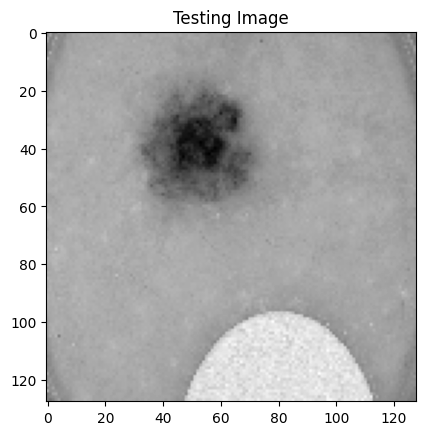

In [ ]:
import random
from tensorflow.keras.utils import normalize
test_img_number = 122
test_img = X_test_do[test_img_number]
ground_truth=Y_test_d0[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')




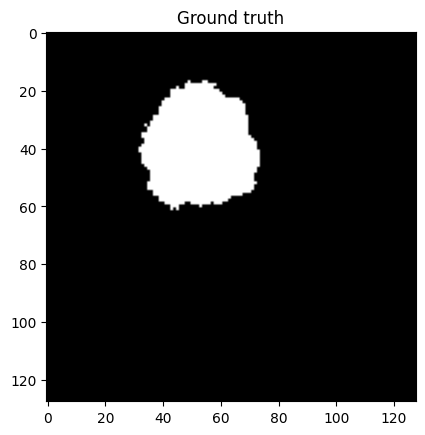

In [ ]:

plt.title('Ground truth')
plt.imshow(ground_truth[:,:,0], cmap='gray')

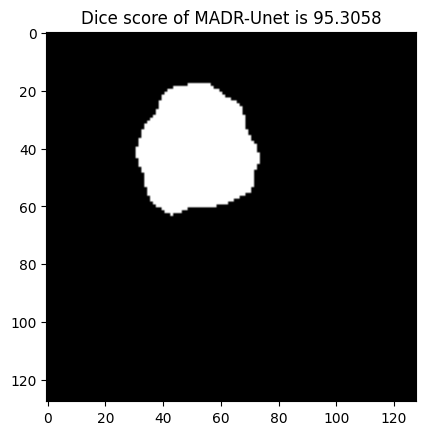

In [ ]:
test_img_number =122
test_img = X_test_do[test_img_number]
ground_truth=Y_test_d0[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

seg=prediction
gt=ground_truth[:,:,0]
dice = (np.sum(seg[gt==1])*2.0 / (np.sum(seg) + np.sum(gt)))*100
dice=round(dice,4)
plt.title(f"Dice score of MADR-Unet is {dice}",fontsize=12)
plt.imshow(prediction, cmap='gray')